# Tiles Extracting from Slides for Data Generation
Details can be found in this [notebook](https://colab.research.google.com/drive/1-T0TNFo205CncJvNQiLdkPQSevSq--V7?usp=sharing)

# Import Libraries

In [16]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray

import numpy as np
import tensorflow as tf
import pandas as pd
import os
import pickle
import random
import shutil
import time

from PIL import Image
from sklearn.model_selection import train_test_split
import IPython.display as display
import glob

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, LSTM, Embedding, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential

from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from keras.optimizers import Adam, RMSprop

# Load Data and Preprocess

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 299
SHUFFLE_SIZE = 10000
BUFFER_SIZE = 10000

# user input for zoom levels, lvl_1 is higher resolution
lvl_1 = 0
lvl_2 = 2

In [19]:
# function to display image pairs from different levels
def plot_image_pair(high_path, low_path):
  """
  Plot a specifc tile with mask overlayyed
  high_path represents the tile png with higher resolution
  low_path represents the tile png with lower resolution
  """
  img_info = high_path.split('/')[-1]
  
  # Parse the information
  is_tumor, slide_num, img_num, x, y, lvl = img_info.split('_')
  lvl = lvl.split('.')[0]
  is_tumor = 'tumor' == is_tumor
  # Convert to Level 0 Coordinate
  x_cor = int(x)*299*(2**int(lvl))
  y_cor = int(y)*299*(2**int(lvl))


  fig, axes = plt.subplots(1, 2, figsize=(16, 8))

  # Get the corresponding mask
  mask_high_path = high_path.replace('/img/', '/mask/')
  mask_low_path = low_path.replace('/img/', '/mask/')
  
  
  l2 = mpimg.imread(high_path) 
  l4 = mpimg.imread(low_path) 
  l2_mask = mpimg.imread(mask_high_path) 
  l4_mask = mpimg.imread(mask_low_path) 
  l2_mask = l2_mask[:,:,0]
  l4_mask = l4_mask[:,:,0]
 
  axes[0].imshow(l4)
  # axes[0].imshow(l4_mask, alpha=0.4,cmap = 'jet')
  axes[0].imshow(l4_mask, alpha=0.4,cmap = 'jet', vmin=0, vmax=0.004) # scale to make sure it works when all red
  axes[0].title.set_text('Low Resolution Tile \nCorresponding high reso tile centered at red box')

  rect = patches.Rectangle((113, 113), 75, 75, linewidth=1, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  axes[0].add_patch(rect)

  axes[1].imshow(l2)
  axes[1].imshow(l2_mask, alpha=0.4,cmap = 'jet', vmin=0, vmax=0.004)
  axes[1].title.set_text('High Resolution Tile')

  title = f'Slide: {slide_num}, Tile Coordinate (Lvl 0) x: {x}, y: {y}, \n Tumor status: {is_tumor}'
  if is_tumor:
    title += '! (Red mask indicate tumor tissues)'
  fig.suptitle(title)
  return

In [29]:
# connect to google drive
from google.colab import drive 
drive.mount('/content/gdrive/', force_remount=True) 

Mounted at /content/gdrive/


In [6]:
os.chdir("/content/gdrive/MyDrive/adl_project")

## Read in images from two above-defined levels

In [38]:
# This is the tiles extracted based on level 0 slide 299*299 boxes, from 10 selected slides
lvl_1_data = glob.glob(f'/content/gdrive/MyDrive/patches_v3/img/*_{lvl_1}.png')
lvl_2_data = glob.glob(f'/content/gdrive/MyDrive/patches_v3/img/*_{lvl_2}.png')

In [39]:
print(f'we have {len(lvl_1_data)} level {lvl_1} samples')
print(f'we have {len(lvl_2_data)} level {lvl_2} samples')

we have 10000 level 0 samples
we have 10000 level 2 samples


In [40]:
data_path = []
slides = set()
for img in lvl_1_data:
  img_info = img.split('/')[-1]
  is_tumor, slide_num, img_number, x, y, _ = img_info.split('_')
  is_tumor = 'tumor' == is_tumor
  slides.add(slide_num)
  data_path.append('_'.join(img_info.split('_')[:-1]))

data_path[:3]

['tumor_101_215_123786_23920',
 'tumor_101_216_26910_17940',
 'tumor_101_217_117208_22724']

In [46]:
slides = list(slides)
print(f'There are in total {len(slides)} slides')
slides

There are in total 10 slides


['101', '016', '084', '110', '075', '096', '091', '078', '064', '031']

In [42]:
# take a look at lvl_1_data and lvl_2_data
lvl_1_data[:5]

['/content/gdrive/MyDrive/patches_v3/img/tumor_101_215_123786_23920_0.png',
 '/content/gdrive/MyDrive/patches_v3/img/tumor_101_216_26910_17940_0.png',
 '/content/gdrive/MyDrive/patches_v3/img/tumor_101_217_117208_22724_0.png',
 '/content/gdrive/MyDrive/patches_v3/img/tumor_101_224_28106_16744_0.png',
 '/content/gdrive/MyDrive/patches_v3/img/tumor_101_225_43056_22724_0.png']

In [43]:
lvl_2_data[:5]

['/content/gdrive/MyDrive/patches_v3/img/tumor_101_208_95680_14950_2.png',
 '/content/gdrive/MyDrive/patches_v3/img/tumor_101_211_28704_16744_2.png',
 '/content/gdrive/MyDrive/patches_v3/img/tumor_101_212_23920_16744_2.png',
 '/content/gdrive/MyDrive/patches_v3/img/tumor_101_215_123786_23920_2.png',
 '/content/gdrive/MyDrive/patches_v3/img/tumor_101_219_100464_14950_2.png']

In [44]:
# check if all images are in pairs
for i in lvl_1_data:
  assert i.replace(f'_{lvl_1}.png', f'_{lvl_2}.png') in lvl_2_data

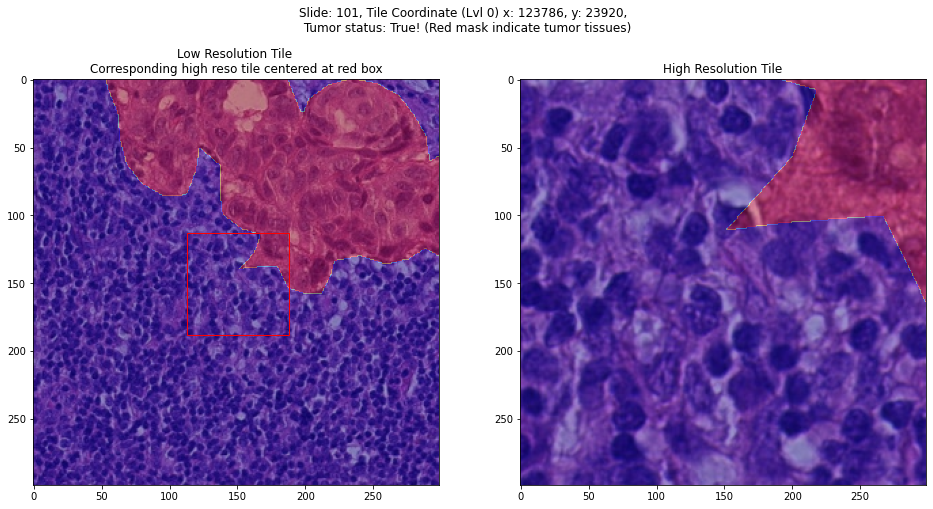

In [45]:
img = lvl_1_data[0]
plot_image_pair(img, img.replace(f'_{lvl_1}.png', f'_{lvl_2}.png'))

/content/gdrive/MyDrive/patches_v3/img/normal_096_657_108238_19734_0.png
/content/gdrive/MyDrive/patches_v3/img/tumor_101_330_43654_19734_0.png
/content/gdrive/MyDrive/patches_v3/img/normal_084_826_23322_19136_0.png


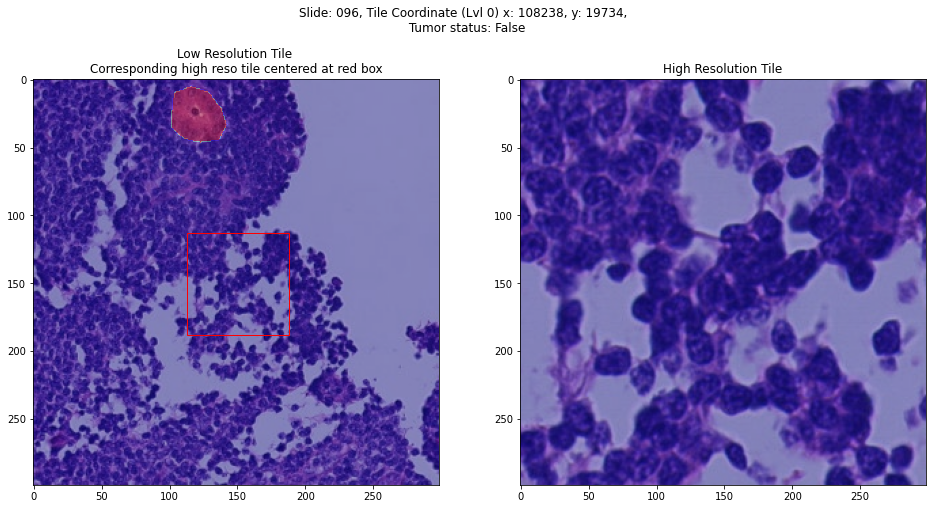

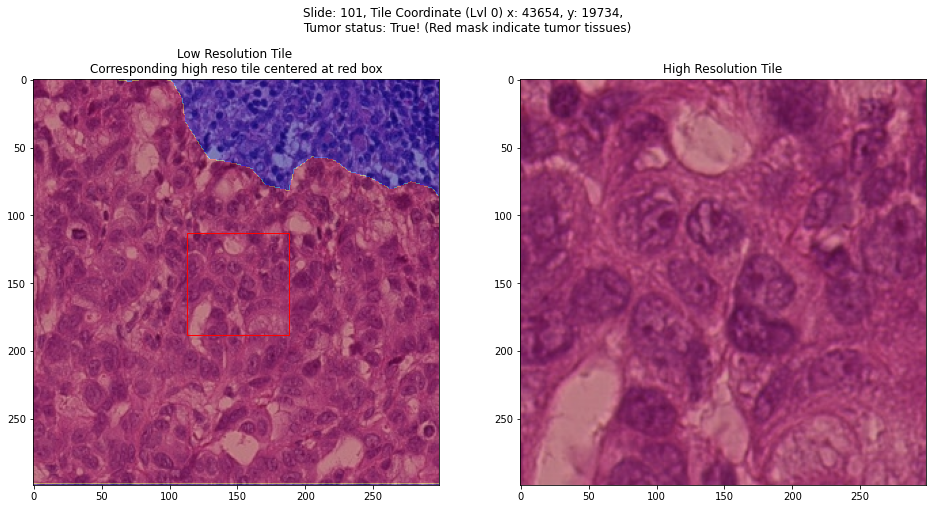

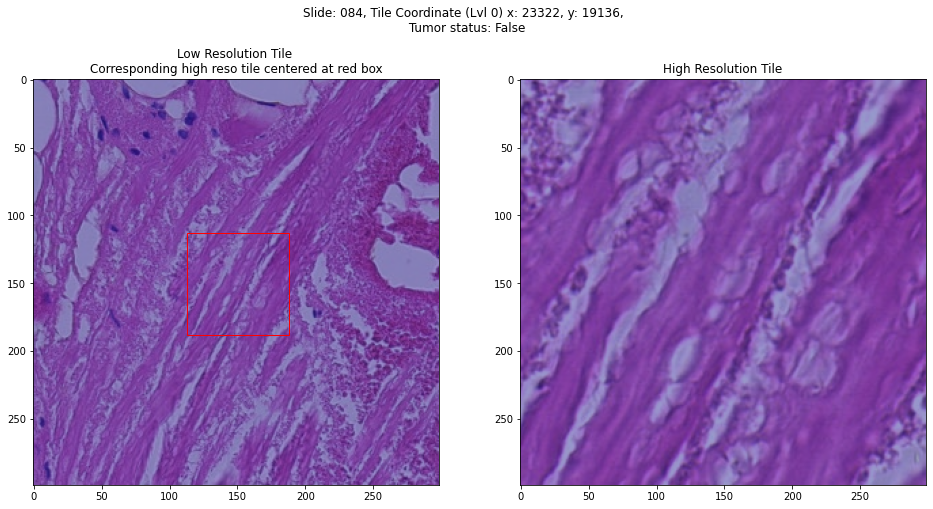

In [69]:
# display some samples
for i in range(3):
  j = random.randint(0,len(lvl_1_data)-1)
  img = lvl_1_data[j]
  print(img)
  plot_image_pair(img, img.replace(f'_{lvl_1}.png', f'_{lvl_2}.png'))

## Train, validation, test split


### Leave 3 slides as test slides (unseen by the model)

In [48]:
# use 3 slides as test slides
test_slides = ['091', '075','096'] 
train_slides = [item for item in slides if item not in test_slides]

In [49]:
# make sure all images from the 3 slides in lvl_1_data and lvl_2_data goes to test set
lvl_1_train = []
lvl_1_test = []
for img in lvl_1_data:
  img_info = img.split('/')[-1]
  is_tumor, slide_num, img_num, x, y, _ = img_info.split('_')
  if slide_num in train_slides:
    lvl_1_train.append(img)
  else:
    lvl_1_test.append(img)

In [50]:
print(len(lvl_1_train), len(lvl_1_test))

7000 3000


In [51]:
lvl_2_train = []
lvl_2_test = []
for img in lvl_2_data:
  img_info = img.split('/')[-1]
  is_tumor, slide_num, img_num, x, y, _ = img_info.split('_')
  if slide_num in train_slides:
    lvl_2_train.append(img)
  else:
    lvl_2_test.append(img)

In [52]:
print(len(lvl_2_train), len(lvl_2_test))

7000 3000


In [53]:
train_labels = [0]*len(lvl_1_train)
for i in range(len(lvl_1_train)):
  if 'normal' not in lvl_1_train[i]:
    train_labels[i] = 1
print(f'total training samples {len(train_labels)}, including {sum(train_labels)} positives')

total training samples 7000, including 3500 positives


In [54]:
test_labels = [0]*len(lvl_1_test)
for i in range(len(lvl_1_test)):
  if 'normal' not in lvl_1_test[i]:
    test_labels[i] = 1
print(f'total test samples {len(test_labels)}, including {sum(test_labels)} positives')

total test samples 3000, including 1500 positives


### Create training and validation set
make sure the 1-1-1 relationship between level_1 image, level_2 image and label

In [55]:
x1_train, x1_val, y_train, y_val = train_test_split(lvl_1_train, train_labels)

In [56]:
# make sure lvl_1 and lvl_2 from the same image go to train or val together
train_path = []
for img in x1_train:
  img_info = img.split('/')[-1]
  train_path.append('_'.join(img_info.split('_')[:-1]))
  
val_path = []
for img in x1_val:
  img_info = img.split('/')[-1]
  val_path.append('_'.join(img_info.split('_')[:-1]))

In [57]:
x2_train = []
x2_val = []
for img in lvl_2_train:
  img_info = img.split('/')[-1]
  path = '_'.join(img_info.split('_')[:-1])
  if path in train_path:
    x2_train.append(img)
  else:
    x2_val.append(img) 

In [58]:
nested_train = list(zip(x1_train, y_train))

In [59]:
nested_train.sort()
nested_train[:5]

[('/content/gdrive/MyDrive/patches_v3/img/normal_016_500_31096_154284_0.png',
  0),
 ('/content/gdrive/MyDrive/patches_v3/img/normal_016_501_1794_93288_0.png', 0),
 ('/content/gdrive/MyDrive/patches_v3/img/normal_016_502_33488_141128_0.png',
  0),
 ('/content/gdrive/MyDrive/patches_v3/img/normal_016_503_35880_138138_0.png',
  0),
 ('/content/gdrive/MyDrive/patches_v3/img/normal_016_504_52026_220064_0.png',
  0)]

In [60]:
x2_train.sort()
x2_train[:5]

['/content/gdrive/MyDrive/patches_v3/img/normal_016_500_31096_154284_2.png',
 '/content/gdrive/MyDrive/patches_v3/img/normal_016_501_1794_93288_2.png',
 '/content/gdrive/MyDrive/patches_v3/img/normal_016_502_33488_141128_2.png',
 '/content/gdrive/MyDrive/patches_v3/img/normal_016_503_35880_138138_2.png',
 '/content/gdrive/MyDrive/patches_v3/img/normal_016_504_52026_220064_2.png']

In [61]:
x1_train = [item[0] for item in nested_train]
x1_train[:5]

['/content/gdrive/MyDrive/patches_v3/img/normal_016_500_31096_154284_0.png',
 '/content/gdrive/MyDrive/patches_v3/img/normal_016_501_1794_93288_0.png',
 '/content/gdrive/MyDrive/patches_v3/img/normal_016_502_33488_141128_0.png',
 '/content/gdrive/MyDrive/patches_v3/img/normal_016_503_35880_138138_0.png',
 '/content/gdrive/MyDrive/patches_v3/img/normal_016_504_52026_220064_0.png']

In [62]:
y_train = [item[1] for item in nested_train]
y_train[:5]

[0, 0, 0, 0, 0]

In [63]:
# use the same logic to produce validation set
nested_val = list(zip(x1_val, y_val))
nested_val.sort()
x1_val = [item[0] for item in nested_val]
y_val = [item[1] for item in nested_val]
x2_val.sort()

In [64]:
print(len(x1_train), len(x2_train), len(x1_val), len(x2_val))
print(len(y_train), len(y_val))

print(f'positive training samples {sum(y_train)}, negative training samples {len(y_train)-sum(y_train)}')
print(f'positive validation samples {sum(y_val)}, negative test samples {len(y_val)-sum(y_val)}')

5250 5250 1750 1750
5250 1750
positive training samples 2613, negative training samples 2637
positive validation samples 887, negative test samples 863


### Generate data pipeline for model

In [65]:
def load_and_preprocess_image(path1, path2, labels):
  img1 = tf.io.read_file(path1)
  img1 = tf.image.decode_jpeg(img1, channels=3)
  img1 = tf.image.resize(img1, [IMG_SIZE, IMG_SIZE])
  img1 /= 255.0  # normalize pixels to 0,1

  img2 = tf.io.read_file(path2)
  img2 = tf.image.decode_jpeg(img2, channels=3)
  img2 = tf.image.resize(img2, [IMG_SIZE, IMG_SIZE])
  img2 /= 255.0  # normalize pixels to 0,1
  return img1, img2, labels

In [66]:
# here's our final training dataset
train_path_ds = tf.data.Dataset.from_tensor_slices((x1_train, x2_train, tf.cast(y_train, tf.int32)))
train_image_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
my_train_ds = train_image_ds.shuffle(SHUFFLE_SIZE)
my_train_ds = my_train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# here's our final validation dataset
val_path_ds = tf.data.Dataset.from_tensor_slices((x1_val, x2_val,tf.cast(y_val, tf.int32)))
val_image_ds = val_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
my_val_ds = val_image_ds.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [67]:
# confirm shape is expected
my_iterator = iter(my_train_ds)
x1, x2, y = next(my_iterator)

print(x1.shape, 
      x2.shape, 
      y.shape)

(32, 299, 299, 3) (32, 299, 299, 3) (32,)


# Train a model from scratch
Based on experiment from single level model, transfer learning and data augementation didn't improve model performance. Therefore, we decide to train a model from scratch and give user the right to decide if they want to include data augmentation

## Define model with data augmentation


In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip('horizontal_and_vertical',
                      input_shape=(IMG_SIZE,
                                  IMG_SIZE,
                                  3)),
    layers.RandomRotation(0.25),
    layers.RandomBrightness(0.2, value_range=(0, 1))
  ]
)

# apply data augmentation only on lvl_1 (zoomed in)

con1 = tf.keras.Sequential([
    data_augmentation,
        Conv2D(32, kernel_size=(5, 5), input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(5, 5), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2))]
)

in1 = Input(shape=(299,299,3)) 
out1 = con1(in1)

con2 = tf.keras.Sequential([
        Conv2D(32, kernel_size=(5, 5), input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(5, 5), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2))]
)

in2 = Input(shape=(299,299,3)) 
out2 = con2(in2)

merged = concatenate([out1, out2])

flat = Flatten()(merged)
dense1 = Dense(128, activation='relu')(flat)
drop1 = Dropout(.4)(dense1)
final = Dense(1, activation='sigmoid')(drop1)
my_model = Model([in1, in2], final)
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 18, 18, 128)  165632      ['input_1[0][0]']                
                                                                                              

In [ ]:
my_model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Utilities to help us record metrics.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

### Train on a single batch

In [ ]:
# loss =[]
# accuracy = []
# for i in range(60):
#   metrics = my_model.train_on_batch(x=(x1, x2), y=y)
#   loss.append(metrics[0])
#   accuracy.append(metrics[1])

In [ ]:
# epochs_range = range(60)

# plt.figure(figsize=(16, 8))
# plt.plot(epochs_range, accuracy, label='Training Accuracy')
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.legend(loc='lower right')
# plt.title('Training Loss and Accuracy');

### Create checkpoints



In [ ]:
drive_root = '/content/gdrive/MyDrive/adl_project'

# This code will save checkpoints in drive.
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "version3_da")
# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}-{model}.ckpt")

In [ ]:
# Restore the latest checkpoint (if it exists).
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  my_model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


### Train on the whole training dataset

In [ ]:
my_train_loss_history, my_train_acc_history = [], []
my_val_loss_history, my_val_acc_history = [], []

epochs = 10 # Your code here
best_acc = -1
# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for x1, x2, y in my_train_ds:
    result = my_model.train_on_batch(x=[x1,x2], y=y)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  for x1_v, x2_v, y_v in my_val_ds:
    predictions = my_model.predict(x=[x1_v,x2_v])
    val_loss(y_v, predictions)
    val_accuracy(y_v, predictions)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  my_train_loss_history.append(train_loss.result())
  my_train_acc_history.append(train_accuracy.result() * 100)
  my_val_loss_history.append(val_loss.result())
  my_val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  #val_accuracy.reset_states()

  if val_accuracy.result() * 100 > best_acc:
    best_acc = val_accuracy.result() * 100
    # Save a checkpoint after each epoch
    print("Saving weights for best model :)")
    my_model.save_weights(checkpoint_path.format(epoch=epoch,model='myModel_da'))
  val_accuracy.reset_states()

### Plots of training and validation loss and accuracy

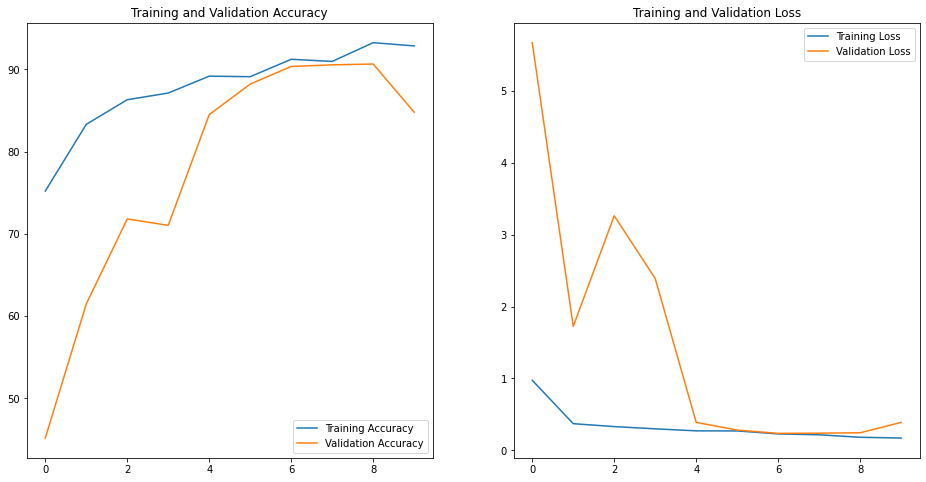

In [ ]:
epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, my_train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, my_val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, my_train_loss_history, label='Training Loss')
plt.plot(epochs_range, my_val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Best Epoch: 9th, Loss: 0.18, Accuracy: 93.23, Val Loss 0.24, Val Accuracy 90.63

## Model without Data Augmentation

In [ ]:
con1 = tf.keras.Sequential([
        Conv2D(32, kernel_size=(5, 5), input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(5, 5), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2))]
)

in1 = Input(shape=(299,299,3)) 
out1 = con1(in1)

con2 = tf.keras.Sequential([
        Conv2D(32, kernel_size=(5, 5), input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(5, 5), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2))]
)

in2 = Input(shape=(299,299,3)) 
out2 = con2(in2)

merged = concatenate([out1, out2])

flat = Flatten()(merged)
dense1 = Dense(128, activation='relu')(flat)
drop1 = Dropout(.4)(dense1)
final = Dense(1, activation='sigmoid')(drop1)

my_model2 = Model([in1, in2], final)
my_model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 18, 18, 128)  165632      ['input_1[0][0]']                
                                                                                              

In [ ]:
my_model2.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

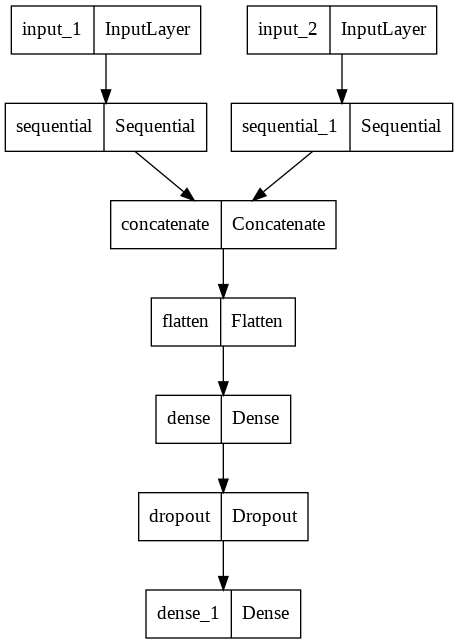

In [ ]:
plot_model(my_model2, to_file='model_multi_2.png')

In [ ]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

### Create checkpoints

In [ ]:
drive_root = '/content/gdrive/MyDrive/adl_project'

# This code will save checkpoints in drive.
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "version3")
# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}-{model}.ckpt")

In [ ]:
# Restore the latest checkpoint (if it exists).
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  my_model2.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

In [ ]:
my_train_loss_history, my_train_acc_history = [], []
my_val_loss_history, my_val_acc_history = [], []

epochs = 10 # Your code here
best_acc = -1
# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for x1, x2, y in my_train_ds:
    result = my_model2.train_on_batch(x=[x1,x2], y=y)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  for x1_v, x2_v, y_v in my_val_ds:
    predictions = my_model2.predict(x=[x1_v,x2_v])
    val_loss(y_v, predictions)
    val_accuracy(y_v, predictions)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  my_train_loss_history.append(train_loss.result())
  my_train_acc_history.append(train_accuracy.result() * 100)
  my_val_loss_history.append(val_loss.result())
  my_val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  #val_accuracy.reset_states()

  if val_accuracy.result() * 100 > best_acc:
    best_acc = val_accuracy.result() * 100
    # Save a checkpoint after each epoch
    print("Saving weights for best model :)")
    my_model2.save_weights(checkpoint_path.format(epoch=epoch,model='myModel_nda'))
  val_accuracy.reset_states()

1/1 [==============================] - 1s 600ms/step
Epoch 0, Loss: 0.53, Accuracy: 81.55, Val Loss 0.88, Val Accuracy 55.31, Time: 116.9 secs
Saving weights for best model :)
1/1 [==============================] - 0s 39ms/step
Epoch 1, Loss: 0.31, Accuracy: 87.41, Val Loss 1.73, Val Accuracy 56.23, Time: 37.6 secs
Saving weights for best model :)
1/1 [==============================] - 0s 34ms/step
Epoch 2, Loss: 0.28, Accuracy: 88.86, Val Loss 0.53, Val Accuracy 68.40, Time: 35.7 secs
Saving weights for best model :)
1/1 [==============================] - 0s 34ms/step
Epoch 3, Loss: 0.28, Accuracy: 88.39, Val Loss 0.23, Val Accuracy 92.74, Time: 35.5 secs
Saving weights for best model :)
1/1 [==============================] - 0s 33ms/step
Epoch 4, Loss: 0.28, Accuracy: 89.36, Val Loss 0.24, Val Accuracy 90.69, Time: 35.5 secs
1/1 [==============================] - 0s 34ms/step
Epoch 5, Loss: 0.26, Accuracy: 91.25, Val Loss 0.18, Val Accuracy 93.43, Time: 35.4 secs
Saving weights for b

### Plots of training and validation loss and accuracy

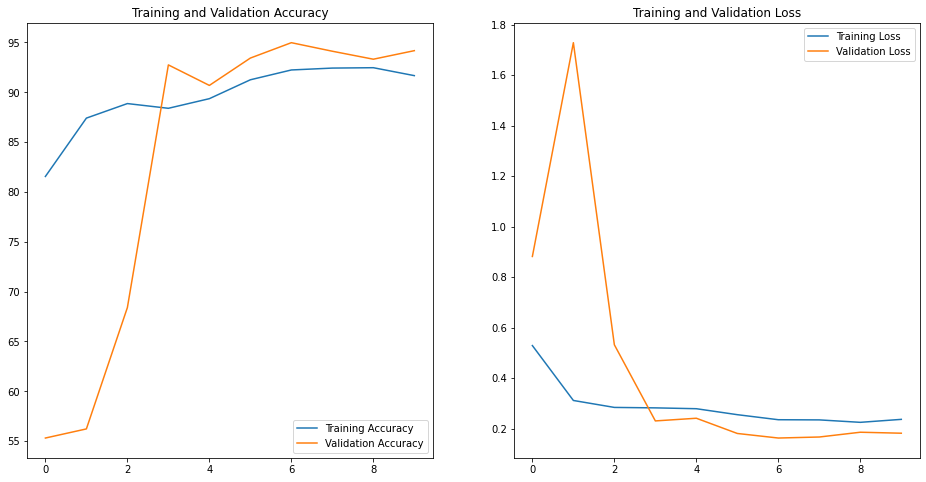

In [ ]:
epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, my_train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, my_val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, my_train_loss_history, label='Training Loss')
plt.plot(epochs_range, my_val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 6, Loss: 0.24, Accuracy: 92.23, Val Loss 0.16, Val Accuracy 94.97,
7th epoch seems to be a good early stop point. 

Model has similar performance to the one with data augementation (DA doesn't help)

In [ ]:
# look at a batch of validation prediction
my_iterator = iter(my_val_ds)
x1, x2, y = next(my_iterator)

print(x1.shape, 
      x2.shape, 
      y.shape)

for prediction2, answer in zip(my_model2.predict(x=[x1, x2]), y):
  #print(x1.numpy())
  print(prediction2, answer.numpy())

(32, 299, 299, 3) (32, 299, 299, 3) (32,)
1/1 [==============================] - 0s 42ms/step
[0.10874422] 1
[0.91286534] 1
[0.3718667] 0
[0.88339263] 1
[0.00626703] 0
[0.07415786] 0
[0.9518926] 1
[0.03851562] 0
[0.01516559] 0
[0.9807233] 1
[0.9916243] 1
[0.17518118] 0
[0.98020166] 1
[0.01182489] 0
[0.986368] 1
[0.20292509] 0
[0.9953199] 1
[0.9875479] 1
[0.997563] 1
[0.94759697] 1
[0.6777717] 1
[0.47616595] 0
[0.9965624] 1
[0.99808466] 1
[0.9591353] 1
[0.00403622] 0
[0.94668937] 1
[0.9877532] 1
[0.01550561] 0
[0.16108464] 0
[0.08677186] 0
[0.9829958] 1


# Evaluate performance on test slides

In [ ]:
drive_root = '/content/gdrive/MyDrive/adl_project'

# This code will save checkpoints in drive.
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "version3")

# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}-{model}.ckpt")

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  my_model2.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /content/gdrive/MyDrive/adl_project/checkpoints/version3/cp-00000006-myModel.ckpt


## Generate confusion matrix for predictions in test set

In [ ]:
test_path_ds = tf.data.Dataset.from_tensor_slices((lvl_1_test, lvl_2_test,tf.cast(test_labels, tf.int32)))
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
my_test_ds = test_image_ds.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# look at performance of images in test dataset
my_iterator = iter(my_test_ds)
x1, x2, y = next(my_iterator)

print(x1.shape, 
      x2.shape, 
      y.shape)

for prediction, answer in zip(my_model2.predict(x=[x1, x2]), y):
  #print(x1.numpy())
  print(prediction, answer.numpy())

In [ ]:
tp = 0
fp = 0
tn = 0
fn = 0
total = 0
for x1, x2, y in my_test_ds:
    predictions = my_model2.predict(x=[x1, x2])
    for pred, ans in zip(predictions,y):
      label = pred[0].round()
      total += 1
      if ans == 1:
        if label == 1:
          tp += 1 
        else:
          fn += 1
      else:
        if label == 1:
          fp += 1 
        else:
          tn += 1
assert total == len(test_labels)

1/1 [==============================] - 0s 24ms/step


In [ ]:
print(total, tp, tn, fp, fn, (tp+tn)/total)

1000 462 464 36 38 0.926


In [ ]:
print(f'''There are {total} images in the test dataset, \n
{total/2} are positive samples, {total/2} are negative samples. \n
{tp} are true positives, \n 
{tn} are true negatives, \n
{fp} are false positives, \n
{fn} are false negatives, \n
accuracy is {(tp+tn)/total}
''')

## Heatmap Calibrated Generation

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    """ Read a region from the slide
    Return a numpy RBG array
    """
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    """ Return tissue pixels for an image
    """
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
  
def apply_mask(im, mask, color=(255,0,0)):
    """ Return the mask as an image
    """
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
def preprocess(cur_batch_high, cur_batch_low):
  X1 = np.asarray(cur_batch_high)
  #X1 = tf.convert_to_tensor(cur_batch_high)
  #print(X1.shape)
  #X1 = tf.image.resize(X1, [IMG_SIZE, IMG_SIZE])
  X1 = X1/255.0

  X2 = np.asarray(cur_batch_low)
  #X2 = tf.convert_to_tensor(cur_batch_low)
  #X2 = tf.image.resize(X2, [IMG_SIZE, IMG_SIZE])
  X2 = X2/255.0
  return X1, X2

In [ ]:
def sliding_infer_cali(image_path, mask_path, model, high_lvl = 0, low_lvl =2, window_size = 299):
  with open_slide(image_path) as slide:
        
    cur_batch_high = []
    cur_batch_low = []
    cur_tiles = []
    labels = []
    
    print(f'total_pixels {pred_mask.shape[0] * pred_mask.shape[1]}')
    for x in range(0, slide.level_dimensions[0][0], window_size*(2**high_lvl)):
      for y in range(0, slide.level_dimensions[0][1], window_size*(2**high_lvl)):
        ratio = (2**low_lvl-2**high_lvl)/2

        # Top Left Coordinate from Low Reso
        x_low = int(x-window_size*ratio)
        y_low = int(y-window_size*ratio)
        # Bottom right Coordinate from Low Reso
        x_low_b = x_low+window_size*(2**low_lvl)
        y_low_r = y_low+window_size*(2**low_lvl)
        
        # Check If Window Pair is Out of bound
        if x_low<0 or y_low<0 or x_low_b>slide.level_dimensions[0][0] or y_low_r>slide.level_dimensions[0][1]:
          continue
        

        high_tile = read_slide(slide, 
                                x = x, 
                                y = y, 
                                level = high_lvl, 
                                width = window_size, 
                                height = window_size, 
                            )
        # Filter Tissue Region, threshold = 0.5
        tissue_pixels = find_tissue_pixels(high_tile)
        tissue_ratio = len(list(tissue_pixels))/(window_size**2)
        if tissue_ratio>0.5:
          low_tile = read_slide(slide, 
                            x = x_low, 
                            y = y_low, 
                            level = low_lvl, 
                            width = window_size, 
                            height = window_size, 
                            )
          cur_batch_high.append(high_tile)
          cur_batch_low.append(low_tile)
          cur_tiles.append((x//299,y//299))
          #print(x, y)
          #print(x_low, y_low)
          if len(cur_tiles) % 500 == 0 and len(cur_tiles)>0: 

            X1, X2 = preprocess(cur_batch_high, cur_batch_low)
            my_pred = model.predict([X1, X2])
            labels.extend(my_pred.squeeze().tolist())
            cur_batch_high = []
            cur_batch_low = []

    X1, X2 = preprocess(cur_batch_high, cur_batch_low)
    my_pred = model.predict_on_batch([X1, X2])
    labels.extend(my_pred.squeeze().tolist())
    cur_batch_high = []
    cur_batch_low = []
    
  return cur_tiles, labels


In [ ]:
pred_tiles_91, labels_91 = sliding_infer_cali('tumor_091.tif','tumor_091_mask.tif', my_model2) 

total_pixels 36695
16/16 [==============================] - 0s 29ms/step


In [ ]:
pred_tiles_78, labels_78 = sliding_infer_cali('/content/gdrive/MyDrive/test_slides/tumor_078.tif', '/content/gdrive/MyDrive/test_slides/tumor_078_mask.tif', my_model2) 

total_pixels 79163
16/16 [==============================] - 0s 28ms/step


In [ ]:
pred_tiles_96, labels_96 = sliding_infer_cali('/content/gdrive/MyDrive/test_slides/tumor_096.tif', '/content/gdrive/MyDrive/test_slides/tumor_096_mask.tif', my_model2) 

total_pixels 104682
16/16 [==============================] - 0s 28ms/step


In [ ]:
def plot_pred_mask_cali(slide, true_mask, pred_mask):
  with open_slide(slide) as slide, open_slide(true_mask) as mask:
    # Slide over level 7
    thumb_slide = slide.get_thumbnail((slide.dimensions[0] / 299, slide.dimensions[1] / 299))
    thumb_mask = mask.get_thumbnail((slide.dimensions[0] / 299, slide.dimensions[1] / 299))
    thumb_slide = np.asarray(thumb_slide)
    thumb_mask = np.asarray(thumb_mask)[:,:,0]


    mask_image_lev7 = read_slide(mask, 
                            x=0, 
                            y=0, 
                            level=7, 
                            width=mask.level_dimensions[7][0], 
                            height=mask.level_dimensions[7][1]
                            )

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    mask_image_lev7 = mask_image_lev7
    axes[0].imshow(thumb_slide)
    axes[0].imshow(thumb_mask, cmap='jet', alpha=0.4)
    axes[0].title.set_text('True Label')

    axes[1].imshow(thumb_slide)
    axes[1].imshow(pred_mask, cmap='jet', alpha=0.4)
    axes[1].title.set_text('Pred Label')

In [ ]:
def plot_pred(slide_path, mask_path, tiles, labels):
  slide = open_slide(slide_path)
  pred_mask1 = np.zeros((slide.level_dimensions[0][1]//299, slide.level_dimensions[0][0]//299))
  save_path = slide_path.replace('.tif', '_pred.npy')
  for loc, label in zip(tiles, labels):
      if label>0.5:
        pred_mask1[loc[1]][loc[0]] = 1
  np.save(save_path, pred_mask1)
  plot_pred_mask_cali(slide_path, mask_path, pred_mask1)

### generate heatmap for train slide 078

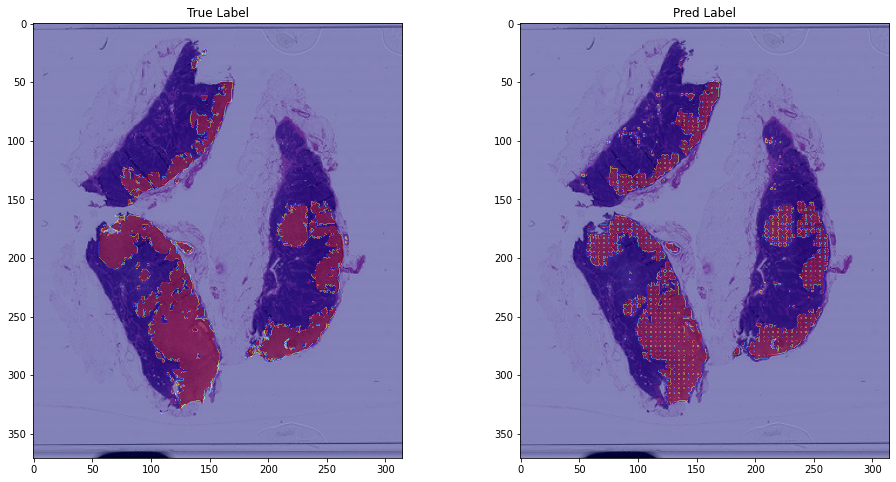

In [ ]:
plot_pred('/content/gdrive/MyDrive/test_slides/tumor_078.tif', '/content/gdrive/MyDrive/test_slides/tumor_078_mask.tif', pred_tiles_78, labels_78)

### generate heatmap for test slide 091

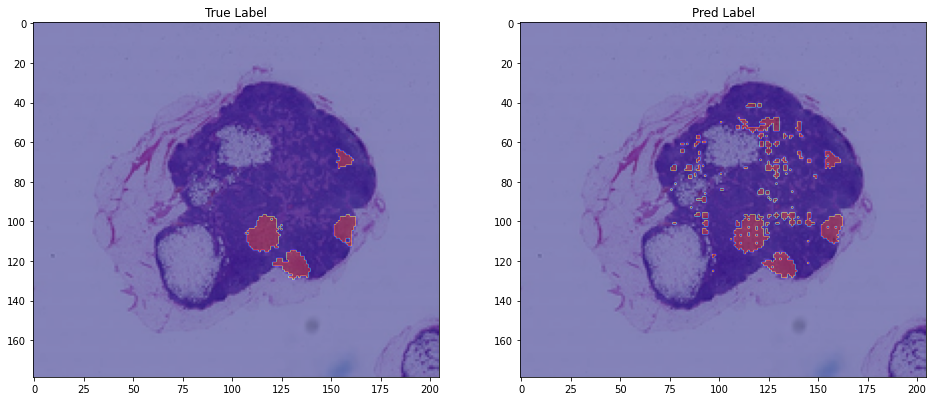

In [ ]:
plot_pred('tumor_091.tif','tumor_091_mask.tif', pred_tiles_91, labels_91)